We apply an ARIMA method to decompose the time series with electricity prices.

# Price obtained from OMIE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Load the electricity price data from CSV into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/precio electricidad OMIE/marginalpdbc20182023.csv', index_col=0)

# Replace "*" values with NaN
df = df.replace('*', np.nan)
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Drop duplicate records based on 'timestamp' column, keeping the first appearance
df.drop_duplicates(subset='timestamp', keep='first', inplace=True)

# Set the 'timestamp' column as the DataFrame index
df.set_index('timestamp', inplace=True)

# Clean missing values by filling them with the previous valid value
df['price'].fillna(method='ffill', inplace=True)


In [2]:
# Group by 1-day periods and aggregate the desired statistics
grouped_df = df.resample('D').agg({
    'price': ['mean', 'first', 'max', 'min', 'last']
})

# Flatten MultiIndex and rename columns
grouped_df.columns = grouped_df.columns.droplevel()
grouped_df.columns = ['Price', 'Open', 'High', 'Low', 'Close']

# Display the grouped DataFrame
print(grouped_df)

                 Price    Open    High     Low   Close
timestamp                                             
2018-01-01   25.575652   28.10   33.00   19.84   28.10
2018-01-02   40.395000   27.60   55.54   19.10   50.50
2018-01-03   45.659167   39.63   54.45   28.10   51.01
2018-01-04   45.440833   41.69   50.08   39.10   48.11
2018-01-05   44.158750   40.00   61.01   13.51   58.05
...                ...     ...     ...     ...     ...
2023-06-14   85.797917   98.38  114.69   66.17  114.21
2023-06-15  104.306250  105.00  146.80   90.00  146.80
2023-06-16  121.832083  118.68  156.13   99.70  151.85
2023-06-17   99.300000  138.18  142.00   50.00  142.00
2023-06-18  136.650000  136.65  136.65  136.65  136.65

[1995 rows x 5 columns]


We save it in a file for further analysis.

In [ ]:
grouped_df.to_csv('/content/drive/MyDrive/PHB009/dataset/precio electricidad OMIE/DailyPrice.csv')

We calculate the daily average before applying ARIMA.

<ipython-input-3-ed316747596c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.resample('D').mean()


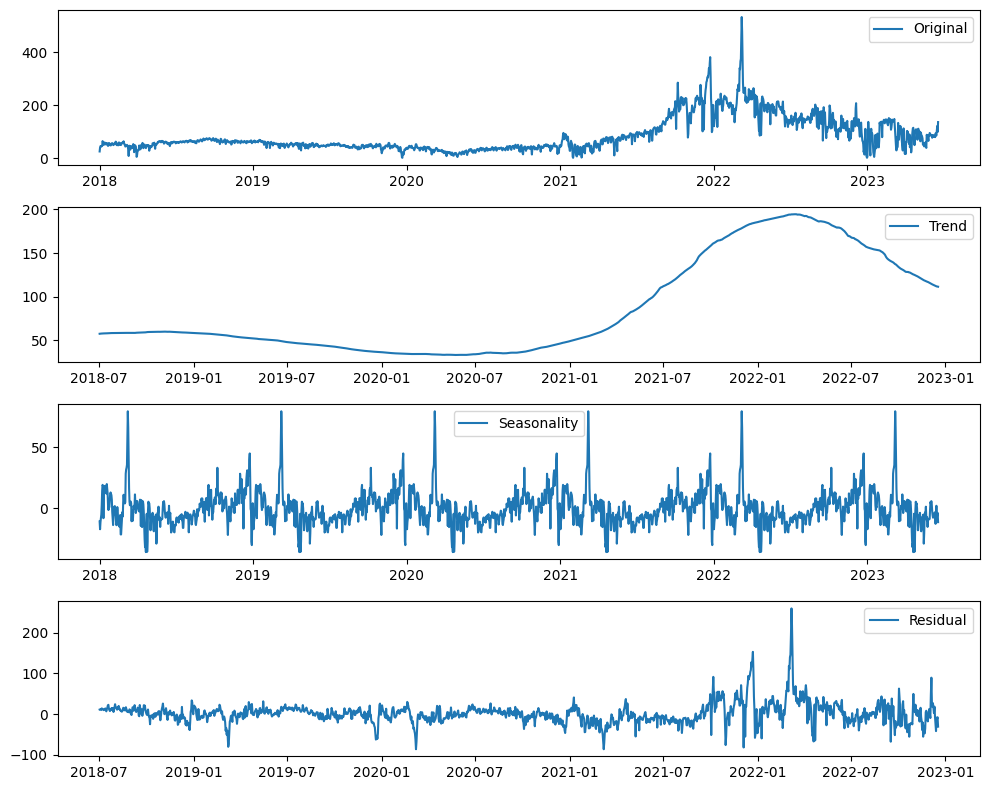

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


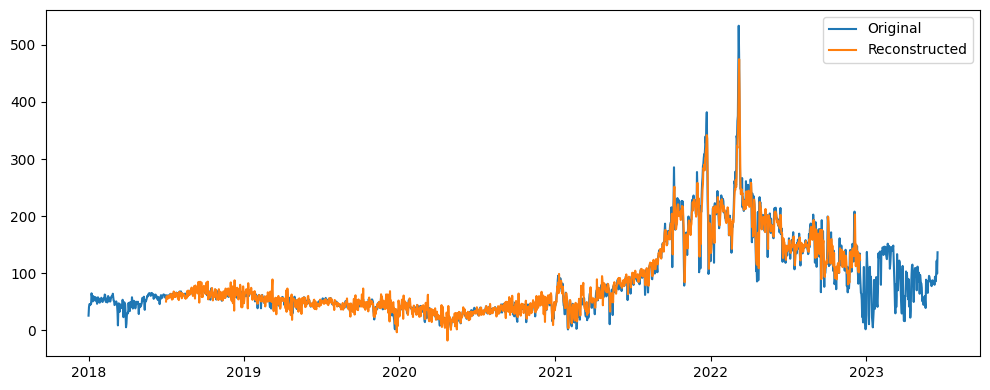

In [3]:
# Calculate the average price per day
df_daily = df.resample('D').mean()

# Perform seasonal decomposition to extract trend, seasonality, and residual (noise)
decomposition = seasonal_decompose(df_daily['price'], model='additive', period=365)

# Get the individual components
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df_daily['price'], label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Fit an ARIMA model to the residual component
model = ARIMA(residual, order=(1, 0, 1))  # Adjust the order as needed
model_fit = model.fit()

# Generate predictions for the residual component
residual_predictions = model_fit.predict(start=0, end=len(residual)-1)

# Reconstruct the decomposed series by adding the trend, seasonality, and predicted residuals
reconstructed = trend + seasonality + residual_predictions

# Plot the reconstructed series
plt.figure(figsize=(10, 4))
plt.plot(df_daily['price'], label='Original')
plt.plot(reconstructed, label='Reconstructed')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Annual Comparison

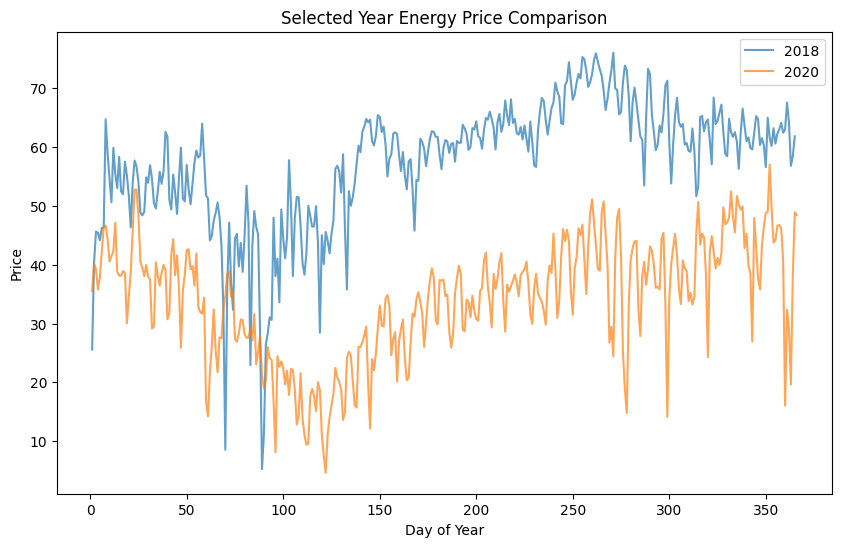

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the data from a CSV file
data = df_daily.copy()

# Extract the years from the data
years = data.index.year.unique()

# Select specific years to display
selected_years = [2018, 2020]

# Plotting the graph
plt.figure(figsize=(10, 6))  # Set the figure size

for year in selected_years:
    if year in years:
        year_data = data[data.index.year == year]
        year_data = year_data.groupby([year_data.index.month, year_data.index.day]).mean()
        x = np.arange(1, len(year_data) + 1)
        plt.plot(x, year_data['price'], label=str(year), alpha=0.7)

plt.xlabel('Day of Year')
plt.ylabel('Price')
plt.title('Selected Year Energy Price Comparison')
plt.legend()  # Show the legend with year labels

plt.show()  # Display the graph
